In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [4]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [7]:
# устранение выбросов
Q1 = df['IC50, mM'].quantile(0.25)
Q3 = df['IC50, mM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['IC50, mM'] >= lower_bound) & (df['IC50, mM'] <= upper_bound)]

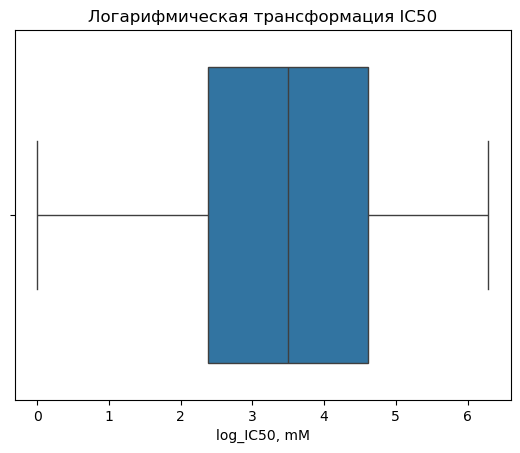

In [9]:
# Логарифмическая трансформация
df['log_IC50, mM'] = np.log(df['IC50, mM'] + 1)
sns.boxplot(x=df['log_IC50, mM'])
plt.title('Логарифмическая трансформация IC50')
plt.show()

In [11]:
df = df.drop(df.columns[[0]], axis=1)

In [13]:
df = df.drop(df.columns[[0]], axis=1)

In [15]:
df = df.drop(df.columns[[1]], axis=1)
df.head()

,"CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_IC50, mM"
0,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,3,0,1.979535
1,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,3,0,0.572014
2,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,3,0,5.415250
3,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,4,0,0.995333
4,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,4.683348


In [17]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_IC50, mM']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
MinEStateIndex и fr_alkyl_halide: корреляция = -0.82
SPS и FractionCSP3: корреляция = 0.86
MolWt и HeavyAtomMolWt: корреляция = 1.00
MolWt и ExactMolWt: корреляция = 1.00
MolWt и NumValenceElectrons: корреляция = 0.98
MolWt и BertzCT: корреляция = 0.90
MolWt и Chi0: корреляция = 0.99
MolWt и Chi0n: корреляция = 0.93
MolWt и Chi0v: корреляция = 0.95
MolWt и Chi1: корреляция = 0.99
MolWt и Chi1n: корреляция = 0.90
MolWt и Chi1v: корреляция = 0.92
MolWt и Kappa1: корреляция = 0.96
MolWt и Kappa2: корреляция = 0.90
MolWt и LabuteASA: корреляция = 0.99
MolWt и HeavyAtomCount: корреляция = 0.99
MolWt и MolMR: корреляция = 0.96
HeavyAtomMolWt и MolWt: корреляция = 1.00
HeavyAtomMolWt и ExactMolWt: корреляция = 1.00
HeavyAtomMolWt и NumValenceElectrons: корреляция = 0.96
HeavyAtomMolWt и BertzCT: корреляция = 0.93
HeavyAtomMolWt и Chi0: коррел

In [18]:
df_final.head()

,"CC50, mM",MinAbsEStateIndex,qed,NumRadicalElectrons,BCUT2D_MWLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,PEOE_VSA10,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_IC50, mM"
0,175.482382,0.387225,0.417362,0,9.700470,0.193481,3.150503,1.164038,2.187750e+06,0.0,...,0,0,0,0,0,0,0,3,0,1.979535
1,5.402819,0.533868,0.462473,0,9.689226,0.120322,3.150503,1.080362,2.187750e+06,0.0,...,0,0,0,0,0,0,0,3,0,0.572014
2,161.142320,0.543231,0.260923,0,9.681293,-0.922902,3.214947,1.219066,8.610751e+06,0.0,...,0,0,0,0,0,0,0,3,0,5.415250
3,107.855654,0.390603,0.377846,0,9.700497,0.193510,3.179270,1.120513,3.572142e+06,0.0,...,0,0,0,0,0,0,0,4,0,0.995333
4,139.270991,0.270476,0.429038,0,9.700386,0.193687,3.337074,1.136678,1.053758e+08,0.0,...,0,0,0,0,0,0,0,0,0,4.683348


In [19]:
# 20 самых важных признаков
X = df_final.drop(columns=['log_IC50, mM'])
y = df_final['log_IC50, mM']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для IC50 по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для IC50 по их значимости:
CC50, mM             0.486072
VSA_EState8          0.263224
BCUT2D_MWLOW         0.261582
BCUT2D_MRLOW         0.232060
BalabanJ             0.228555
EState_VSA2          0.206523
AvgIpc               0.206413
SlogP_VSA2           0.202364
VSA_EState5          0.201036
VSA_EState4          0.193051
VSA_EState7          0.187324
NHOHCount            0.173520
PEOE_VSA8            0.171235
MolLogP              0.168474
NumAliphaticRings    0.159238
EState_VSA8          0.158611
PEOE_VSA6            0.157174
EState_VSA6          0.156698
PEOE_VSA9            0.153952
PEOE_VSA7            0.151540
dtype: float64


In [20]:
# удаление признаков с важностью менее 0.15
features_to_keep = feature_importances[feature_importances >= 0.15].index
X_drop = X[features_to_keep]

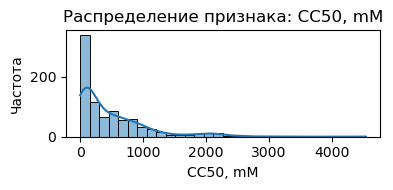

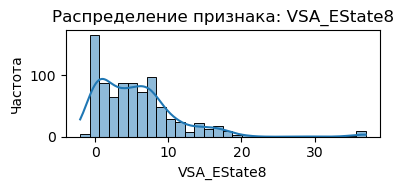

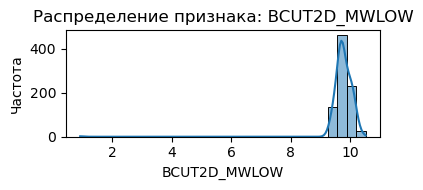

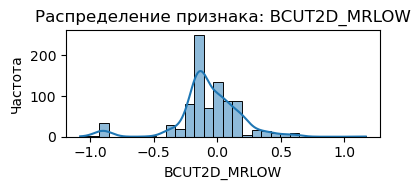

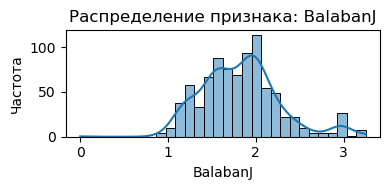

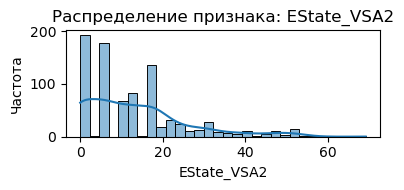

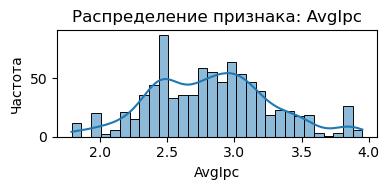

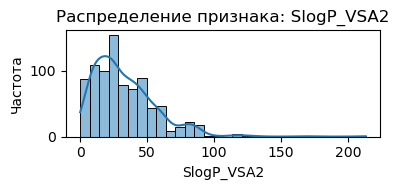

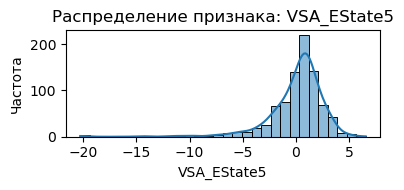

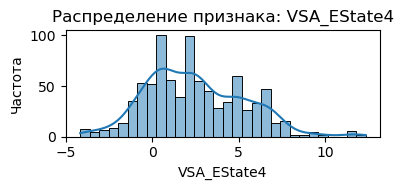

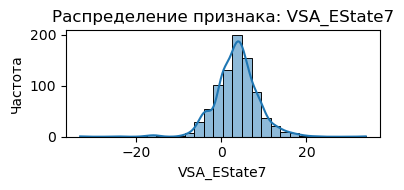

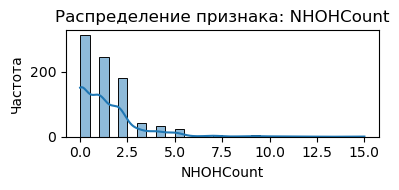

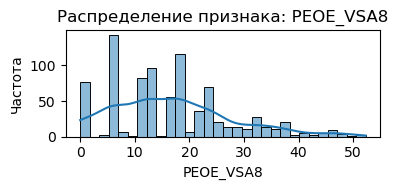

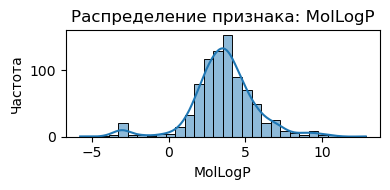

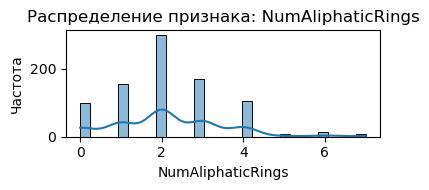

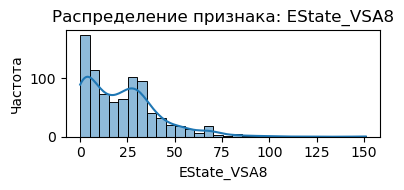

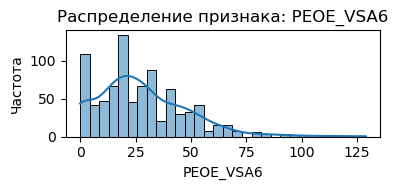

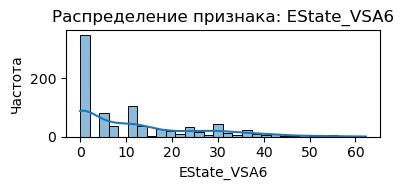

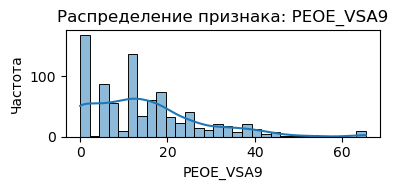

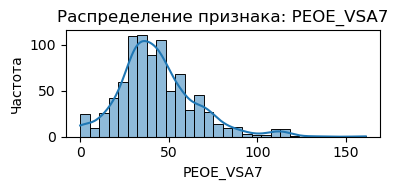

In [21]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [22]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования IC50:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

CC50, mM         2.139940
VSA_EState8      2.198320
BCUT2D_MWLOW   -14.316253
EState_VSA2      1.227072
SlogP_VSA2       1.616195
VSA_EState5     -2.764575
NHOHCount        2.658587
EState_VSA8      1.328023
PEOE_VSA6        1.061022
EState_VSA6      1.166108
PEOE_VSA9        1.180043
dtype: float64
Признаки для логарифмирования IC50: ['CC50, mM', 'VSA_EState8', 'EState_VSA2', 'SlogP_VSA2', 'NHOHCount', 'EState_VSA8', 'PEOE_VSA6', 'EState_VSA6', 'PEOE_VSA9']


In [23]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'CC50, mM': заменено 20 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState8': заменено 2 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'BCUT2D_MWLOW': заменено 2 значений ниже нижней границы и 3 выше верхней границы.
В признаке 'BCUT2D_MRLOW': заменено 36 значений ниже нижней границы и 24 выше верхней границы.
В признаке 'BalabanJ': заменено 1 значений ниже нижней границы и 39 выше верхней границы.
В признаке 'EState_VSA2': заменено 192 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'AvgIpc': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'SlogP_VSA2': заменено 11 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'VSA_EState5': заменено 43 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'VSA_EState4': заменено 0 значений ниже нижней границы и 8 выше верхней границы.
В признаке 'VSA_EState7': заменено 10 значений ниже нижней границы и 15 выше верхн

In [24]:
X_drop.head()

,"CC50, mM",VSA_EState8,BCUT2D_MWLOW,BCUT2D_MRLOW,BalabanJ,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,VSA_EState7,NHOHCount,PEOE_VSA8,MolLogP,NumAliphaticRings,EState_VSA8,PEOE_VSA6,EState_VSA6,PEOE_VSA9,PEOE_VSA7
0,5.167539,2.945262,9.700470,0.193481,1.164038,-0.066507,3.150503,3.199199,1.764908,4.807589,13.258223,-20.723266,35.342864,7.1212,4,3.726715,3.996071,2.435661,-0.195995,74.032366
1,1.686921,2.980878,9.689226,0.120322,1.080362,-0.066507,3.150503,3.225780,1.914377,2.153503,14.135381,0.693147,12.083682,6.1556,4,3.954623,3.996071,-20.723266,-0.195995,91.058370
2,5.082288,3.011693,9.681293,-0.487544,1.219066,-0.066507,3.214947,4.132442,1.930720,2.184127,14.491619,-20.723266,23.671624,7.1292,4,4.244675,3.726715,-20.723266,3.977134,74.032366
3,4.680794,2.946887,9.700497,0.193510,1.120513,-0.066507,3.179270,3.199199,1.769975,4.827852,14.695439,-20.723266,35.342864,7.5113,4,3.726715,4.107670,2.435661,-0.195995,74.032366
4,4.936422,2.817017,9.700386,0.193687,1.136678,2.382318,3.337074,2.435661,1.605178,9.071783,8.627311,-20.723266,22.253351,7.8683,4,4.500624,4.186740,-20.723266,2.431398,91.058370


In [25]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,"CC50, mM",VSA_EState8,BCUT2D_MWLOW,BCUT2D_MRLOW,BalabanJ,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,VSA_EState7,NHOHCount,PEOE_VSA8,MolLogP,NumAliphaticRings,EState_VSA8,PEOE_VSA6,EState_VSA6,PEOE_VSA9,PEOE_VSA7
0,-0.098864,1.551308,-0.398886,1.279154,-1.550720,-1.651637,0.731367,-0.042489,0.763471,0.824885,2.107981,-1.316649,1.689761,1.946135,1.377229,0.837686,1.032880,0.797457,-1.827883,1.552831
1,-2.297003,1.599246,-0.448983,0.900152,-1.749487,-1.651637,0.731367,-0.008039,0.838789,-0.113657,2.300754,0.772657,-0.411943,1.404929,1.377229,0.971191,1.032880,-1.210468,-1.827883,2.400247
2,-0.152703,1.640720,-0.484332,-2.248939,-1.420003,-1.651637,0.877520,1.167042,0.847024,-0.102827,2.379045,-1.316649,0.635146,1.950619,1.377229,1.141099,0.760074,-1.210468,1.416307,1.552831
3,-0.406262,1.553496,-0.398764,1.279307,-1.654110,-1.651637,0.796608,-0.042489,0.766024,0.832050,2.423838,-1.316649,1.689761,2.164781,1.377229,0.837686,1.145908,0.797457,-1.827883,1.552831
4,-0.244823,1.378700,-0.399261,1.280220,-1.615711,0.279567,1.154489,-1.032073,0.682982,2.332794,1.090242,-1.316649,0.506990,2.364874,1.377229,1.291029,1.225991,-1.210468,0.214652,2.400247


In [26]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,"CC50, mM",VSA_EState8,BCUT2D_MWLOW,BCUT2D_MRLOW,BalabanJ,EState_VSA2,AvgIpc,SlogP_VSA2,VSA_EState5,VSA_EState4,VSA_EState7,NHOHCount,PEOE_VSA8,MolLogP,NumAliphaticRings,EState_VSA8,PEOE_VSA6,EState_VSA6,PEOE_VSA9,PEOE_VSA7
0,0.552337,0.821622,0.387107,0.763028,0.204169,0.000000,0.629530,0.479465,0.648633,0.591934,0.929476,0.000000,0.725077,0.912186,0.666667,0.787299,0.782259,0.931792,0.000000,0.813021
1,0.073339,0.830462,0.377033,0.681061,0.164176,0.000000,0.629530,0.485970,0.664253,0.417352,0.968017,0.914008,0.247903,0.798691,0.666667,0.824870,0.782259,0.000000,0.000000,1.000000
2,0.540605,0.838109,0.369924,0.000000,0.230470,0.000000,0.659294,0.707866,0.665961,0.419366,0.983669,0.000000,0.485636,0.913127,0.666667,0.872686,0.714293,0.000000,0.953369,0.813021
3,0.485352,0.822026,0.387132,0.763061,0.183366,0.000000,0.642816,0.479465,0.649163,0.593267,0.992624,0.000000,0.725077,0.958039,0.666667,0.787299,0.810419,0.931792,0.000000,0.813021
4,0.520531,0.789794,0.387032,0.763259,0.191092,0.568973,0.715700,0.292597,0.631941,0.872428,0.726006,0.000000,0.456539,1.000000,0.666667,0.914880,0.830370,0.000000,0.600239,1.000000


In [27]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (725, 20), (725,)
Train dataset size: (129, 20), (129,)


### Обучение моделей

In [39]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search_cb.fit(X_train, y_train)

print("Лучшие параметры для CatBoost:", grid_search_cb.best_params_)
print("Лучший результат (по MAPE):", -grid_search_cb.best_score_)
print("Лучший результат (по MSE):", -grid_search_cb.best_score_)

Linear Regression: MSE = 1.13, MAE = 0.88, R2 = 0.50
Ridge Regression: MSE = 1.13, MAE = 0.88, R2 = 0.50
KNN (KNeighborsRegressor): MSE = 1.06, MAE = 0.82, R2 = 0.53
Random Forest: MSE = 1.06, MAE = 0.82, R2 = 0.53
Gradient Boosting: MSE = 1.01, MAE = 0.80, R2 = 0.55
HistGradientBoosting: MSE = 1.04, MAE = 0.79, R2 = 0.54
AdaBoost: MSE = 1.13, MAE = 0.88, R2 = 0.50
XGBoost: MSE = 1.21, MAE = 0.85, R2 = 0.46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3455
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 20
[LightGBM] [Info] Start training from score 3.510229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

╒═══════════════════════════╤════════╤════════╤════════╕
│                           │    MSE │    MAE │     R2 │
╞═══════════════════════════╪════════╪════════╪════════╡
│ Linear Regression         │ 1.1324 │ 0.8759 │ 0.4984 │
├───────────────────────────┼────────┼────────┼────────┤
│ Ridge Regression          │ 1.1321 │ 0.8758 │ 0.4986 │
├───────────────────────────┼────────┼────────┼────────┤
│ KNN (KNeighborsRegressor) │ 1.0638 │ 0.8164 │ 0.5288 │
├───────────────────────────┼────────┼────────┼────────┤
│ Random Forest             │ 1.0566 │ 0.8201 │ 0.5320 │
├───────────────────────────┼────────┼────────┼────────┤
│ Gradient Boosting         │ 1.0118 │ 0.8024 │ 0.5518 │
├───────────────────────────┼────────┼────────┼────────┤
│ HistGradientBoosting      │ 1.0388 │ 0.7856 │ 0.5399 │
├───────────────────────────┼────────┼────────┼────────┤
│ AdaBoost                  │ 1.1349 │ 0.8779 │ 0.4973 │
├───────────────────────────┼────────┼────────┼────────┤
│ XGBoost                   │ 1

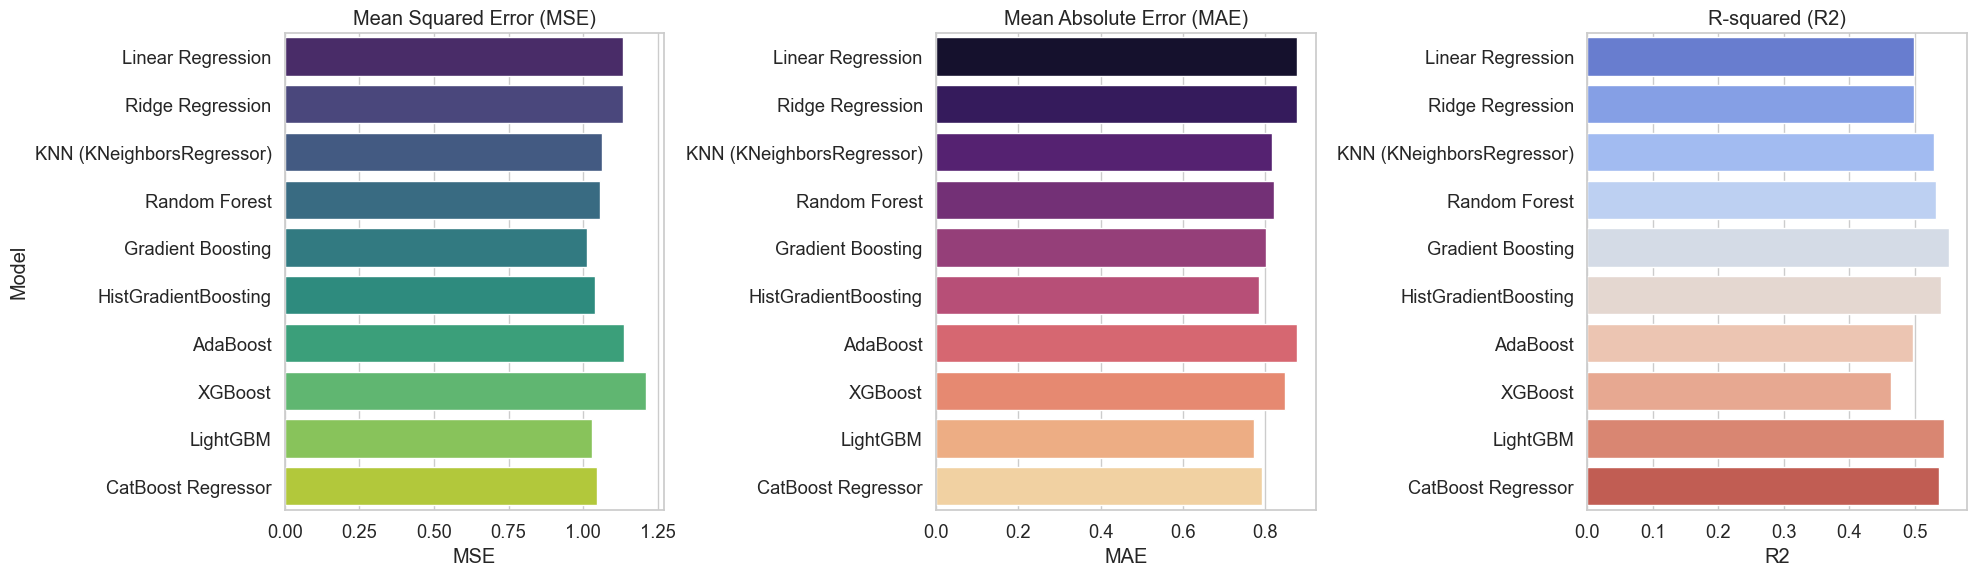

In [40]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [43]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
                 LightGBM 0.677738
       CatBoost Regressor 0.711963
     HistGradientBoosting 0.729114
            Random Forest 0.751344
                  XGBoost 0.769961
KNN (KNeighborsRegressor) 0.841451
        Gradient Boosting 0.881304
                 AdaBoost 1.539220
        Linear Regression 1.597397
         Ridge Regression 1.599010


### Побдор гиперпараметров

In [46]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3455
[LightGBM] [Info] Number of data points in the train set: 725, number of used features: 20
[LightGBM] [Info] Start training from score 3.510229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai